In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00


In [2]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Loading Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

# Check the data
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')


Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [4]:
data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Is undirected: True


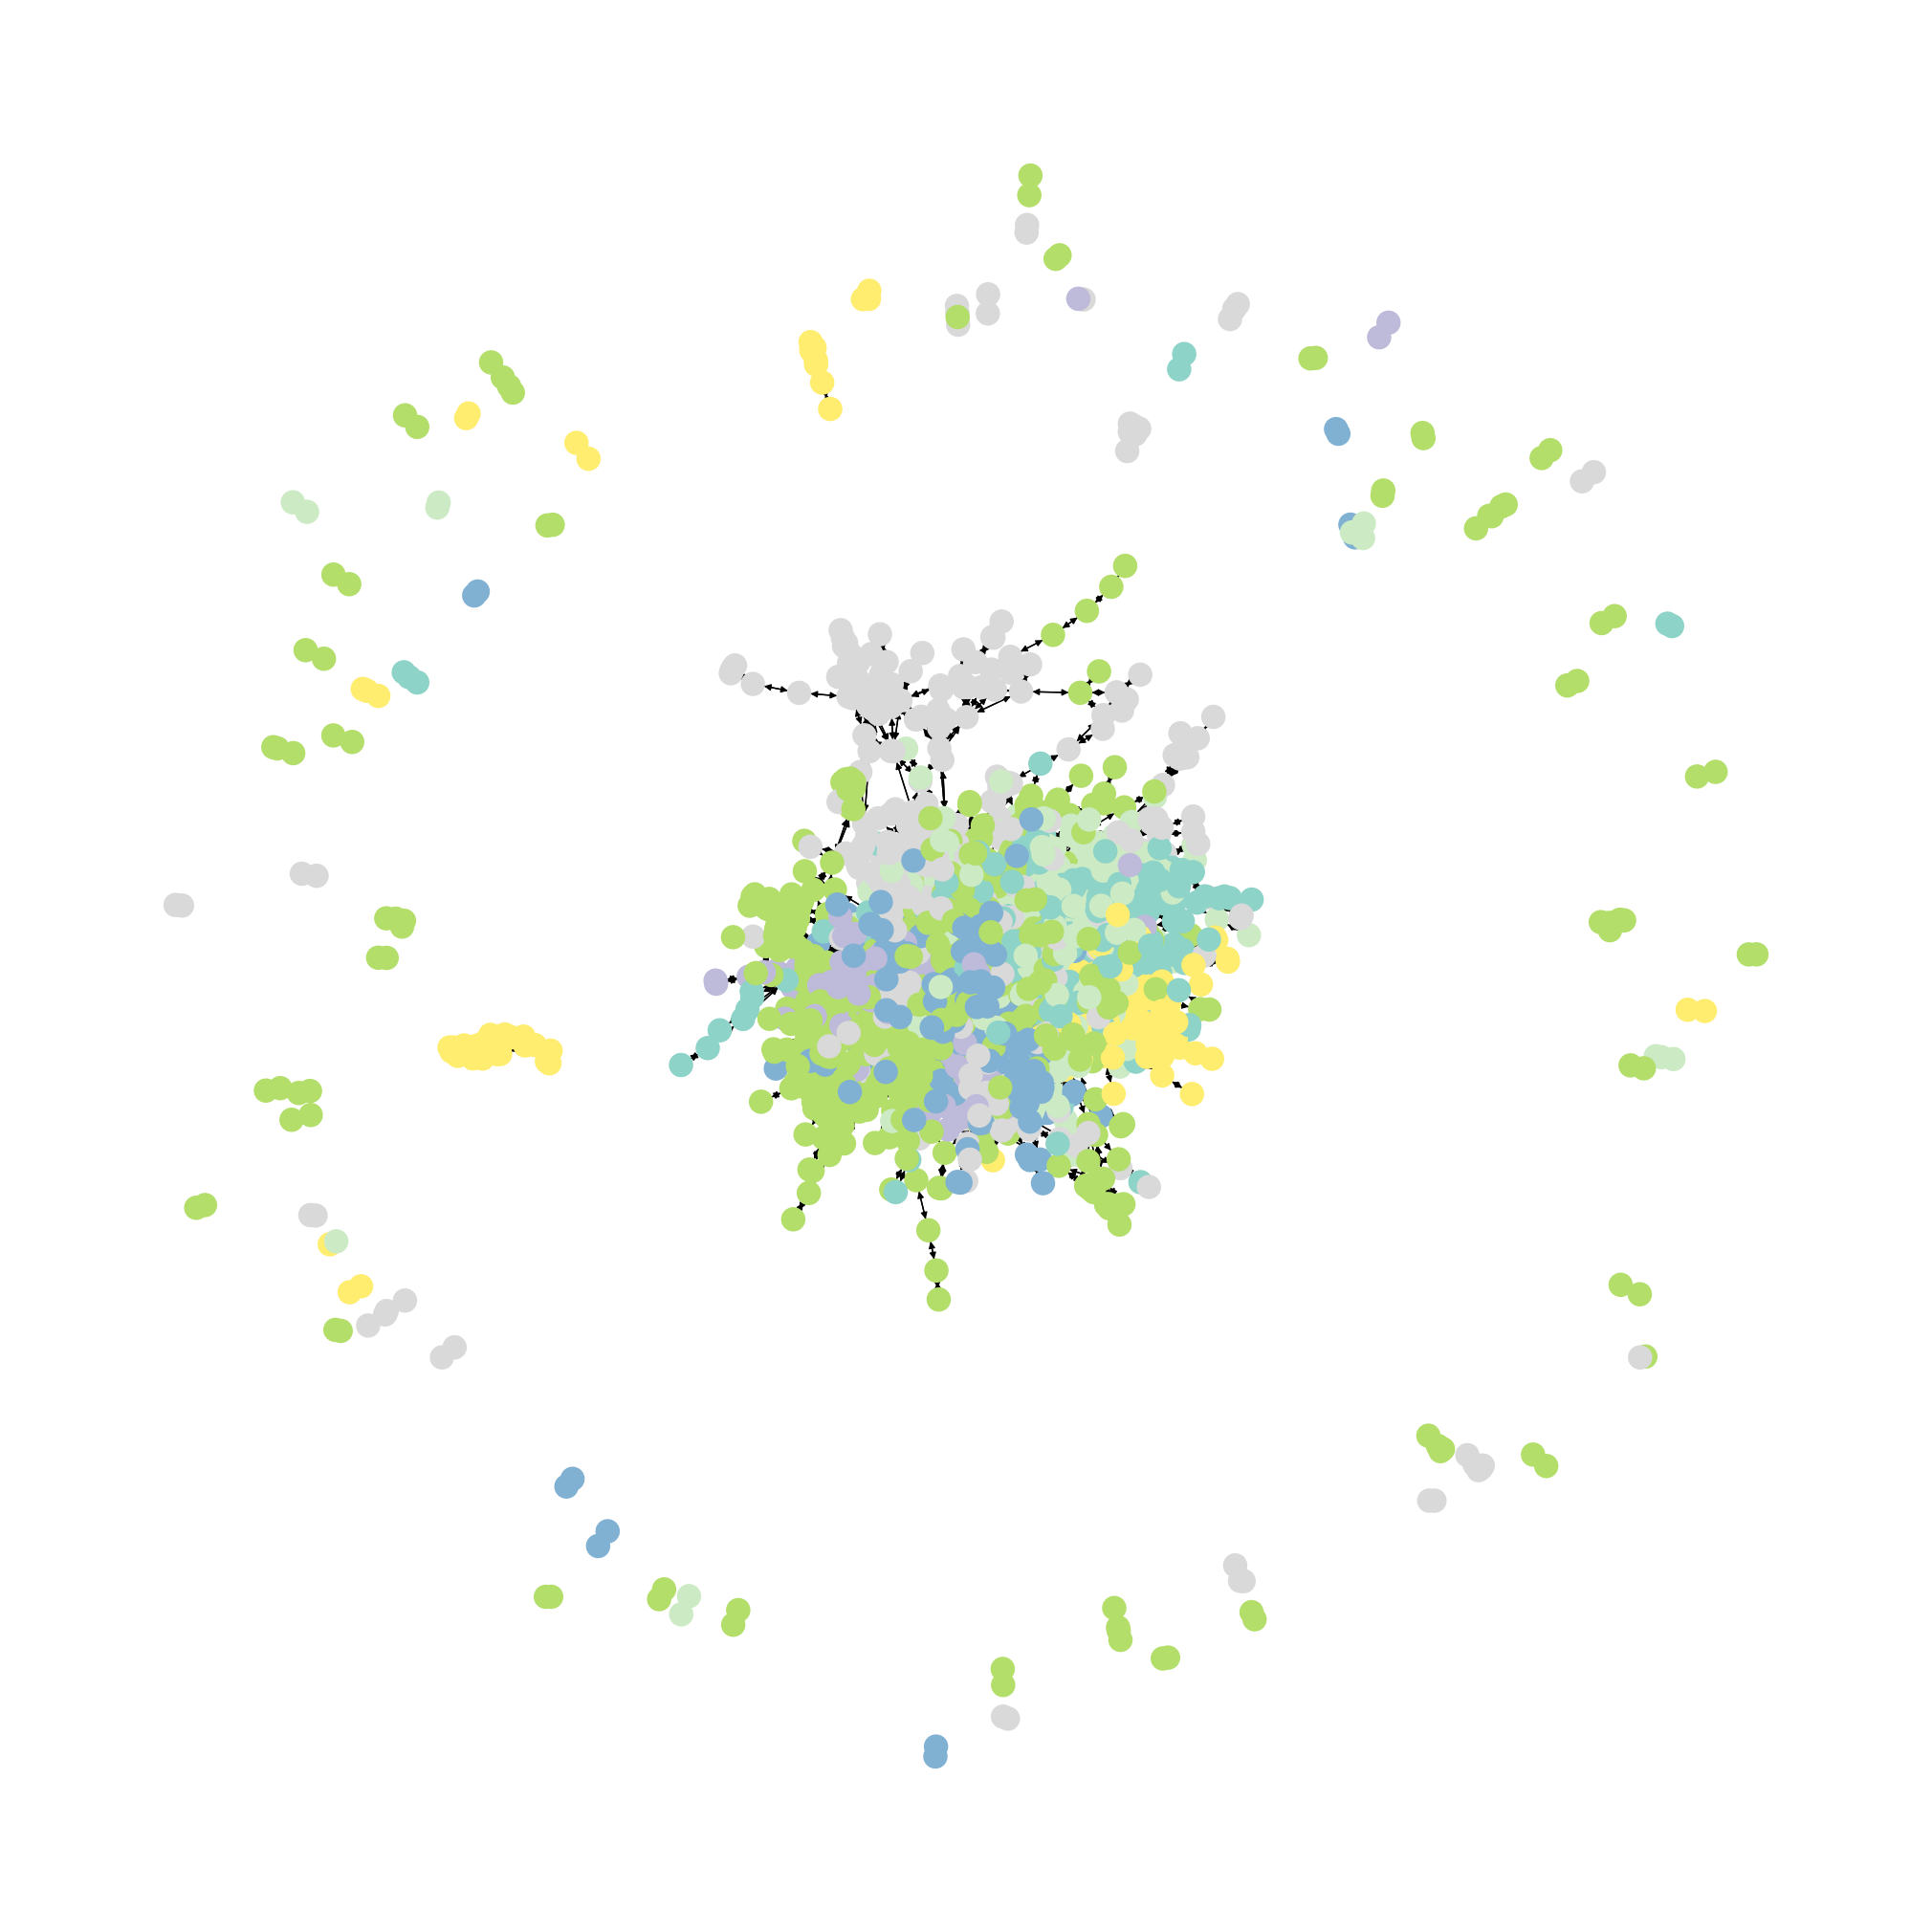

In [5]:
data = dataset[0]
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=False, node_color=data.y, cmap=plt.get_cmap('Set3'))
plt.show()

In [6]:
# https://arxiv.org/abs/1710.10903
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, 128, heads=16, dropout=0.3)
        self.conv2 = GATConv(128 * 16, 64, heads=8, dropout=0.3)
        self.conv3 = GATConv(64 * 8, 16, heads=4, dropout=0.3)
        self.conv4 = GATConv(16 * 4, dataset.num_classes, heads=1, concat=False, dropout=0.3)

        # self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.3)
        # self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=False, dropout=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT()
print(model)

GAT(
  (conv1): GATConv(1433, 128, heads=16)
  (conv2): GATConv(2048, 64, heads=8)
  (conv3): GATConv(512, 16, heads=4)
  (conv4): GATConv(64, 7, heads=1)
)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GAT(in_channels=dataset.num_node_features, out_channels=dataset.num_classes).to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
          _, train_pred = model(data).max(dim=1)
          train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
          train_acc = train_correct / int(data.train_mask.sum().item())

          _, val_pred = model(data).max(dim=1)
          val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
          val_acc = val_correct / int(data.val_mask.sum().item())
          print(f'Epoch {epoch}/{num_epochs - 1}, '
                  f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            # pred_train = out.argmax(dim=1)  # Get the index of the maximum log-probability for training data
            # correct_train = pred_train[data.train_mask].eq(data.y[data.train_mask]).sum().item()
            # train_acc = correct_train / data.train_mask.sum().item()

            # pred_val = out.argmax(dim=1)  # Get the index of the maximum log-probability for validation data
            # correct_val = pred_val[data.val_mask].eq(data.y[data.val_mask]).sum().item()
            # val_acc = correct_val / data.val_mask.sum().item()

            # print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {loss.item():.4f}, '
            #       f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    return model

# Choose the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=25)

Epoch 0/24, Training Accuracy: 0.6214, Validation Accuracy: 0.4460
Epoch 1/24, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 2/24, Training Accuracy: 0.4143, Validation Accuracy: 0.2280
Epoch 3/24, Training Accuracy: 0.6571, Validation Accuracy: 0.4620
Epoch 4/24, Training Accuracy: 0.5143, Validation Accuracy: 0.5420
Epoch 5/24, Training Accuracy: 0.6571, Validation Accuracy: 0.4000
Epoch 6/24, Training Accuracy: 0.7143, Validation Accuracy: 0.4880
Epoch 7/24, Training Accuracy: 0.7071, Validation Accuracy: 0.5020
Epoch 8/24, Training Accuracy: 0.6786, Validation Accuracy: 0.4960
Epoch 9/24, Training Accuracy: 0.7643, Validation Accuracy: 0.6100
Epoch 10/24, Training Accuracy: 0.8071, Validation Accuracy: 0.6560
Epoch 11/24, Training Accuracy: 0.8429, Validation Accuracy: 0.6640
Epoch 12/24, Training Accuracy: 0.9214, Validation Accuracy: 0.7660
Epoch 13/24, Training Accuracy: 0.9429, Validation Accuracy: 0.7640
Epoch 14/24, Training Accuracy: 0.9071, Validation Accurac

In [8]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.7760
